# 시범지역 예측 모델링 및 선정

## 데이터 로드 및 전처리¶

In [2]:
seoul_survey = pd.read_excel('4. 2018 서베이 가구원(원시자료와 부호화 지침서).xlsx')
food_survey = pd.read_excel('2019 식품소비행태조사_주구입자(배포용).xlsx')

## 서울서베이 변수처리

In [3]:
seoul_survey_cleared = seoul_survey.loc[:,['ID','DE1','DE2','ADQ3_6','house','GU','AQ10']]
seoul_survey_cleared.columns = ['ID','gender','age','income','house','gu','WTP']

In [ ]:
# 구별로 정리
mygu = seoul_survey_cleared.groupby(['ID']).mean()['gu'].reset_index(drop=True)

In [7]:
# 가구별 df 생성
seoul_survey_id = seoul_survey_cleared.groupby("ID").mean()
seoul_survey_id['gu'] = mygu

In [8]:
# income 전처리
myincome1 = list(range(1,20))
myincome2 = list(range(50,1000,50))

seoul_survey_cleared['income'] = seoul_survey_cleared['income'].apply(lambda row: row*50)
seoul_survey_id['income'] = seoul_survey_cleared.groupby(['ID'],as_index=False).sum()['income']

In [9]:
# 동거인 연령대 전처리
temp = seoul_survey_cleared.pivot_table(index = "ID", columns = "age", aggfunc = "size").fillna(0)
juvenile = temp.iloc[:,:2].sum(axis=1)
adult = temp.iloc[:,2:].sum(axis=1)

juvenile_cleared = pd.DataFrame(juvenile).reset_index(drop=True)
adult_cleared = pd.DataFrame(adult).reset_index(drop=True)

seoul_survey_id['juvenile'] = juvenile_cleared
seoul_survey_id['adult'] = adult_cleared

In [10]:
# willing to pay maximum value
seoul_survey_id['pay'] = seoul_survey_cleared.groupby(['ID'], as_index=False).max()['WTP']

In [11]:
# 가구형태 처리
house_count = seoul_survey_cleared.groupby(['ID']).mean()['house'].reset_index()
seoul_survey_id['house'] = house_count['house']

## 식품소비행태조사 변수처리

In [12]:
# NaN 0으로 처리
food_survey["G10"] = food_survey["G10"].fillna(0)

In [13]:
# G10문항 결측값 드랍, 컬럼네임 짓기
food_survey_cleared = food_survey[food_survey['G10']!=0].iloc[:,1:]
food_survey_cleared = food_survey_cleared.loc[:,['지역','SQ2','K2','K1','BA2','BA3','G10']]
food_survey_cleared.columns = ['region','gender','juvenile','adult','income','house','baedal']

In [14]:
change_delivery = {
    1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4
}
food_survey_cleared["baedal"] = food_survey_cleared["baedal"].apply(lambda x : change_delivery[x])

In [15]:
mydata = food_survey_cleared.iloc[:,1:].values

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

## 예측 모델링 : 딥러닝

In [17]:
y = mydata[:,-1]
X = mydata[:,:-1]

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [18]:
model = Sequential()
model.add(Embedding(2216, 100))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [21]:
history = model.fit(X_train, y_train, batch_size=256, epochs=50, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.5529 - acc: 0.5333
Epoch 00001: val_acc improved from -inf to 0.60586, saving model to best_model.h5
7/7 [==============================] - 1s 153ms/step - loss: 1.5529 - acc: 0.5333 - val_loss: 1.4617 - val_acc: 0.6059
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.3500 - acc: 0.6179
Epoch 00002: val_acc did not improve from 0.60586
7/7 [==============================] - 0s 40ms/step - loss: 1.3500 - acc: 0.6179 - val_loss: 1.1442 - val_acc: 0.6059
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 1.0016 - acc: 0.6179
Epoch 00003: val_acc did not improve from 0.60586
7/7 [==============================] - 0s 38ms/step - loss: 1.0016 - acc: 0.6179 - val_loss: 0.9142 - val_acc: 0.6059
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.9298 - acc: 0.6179
Epoch 00004: val_acc did not improve from 0.60586
7/7 [==============================] - 0s 39ms/step - loss: 0.929

In [22]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

14/14 [==============================] - 0s 4ms/step - loss: 0.8172 - acc: 0.6306

 테스트 정확도: 0.6306


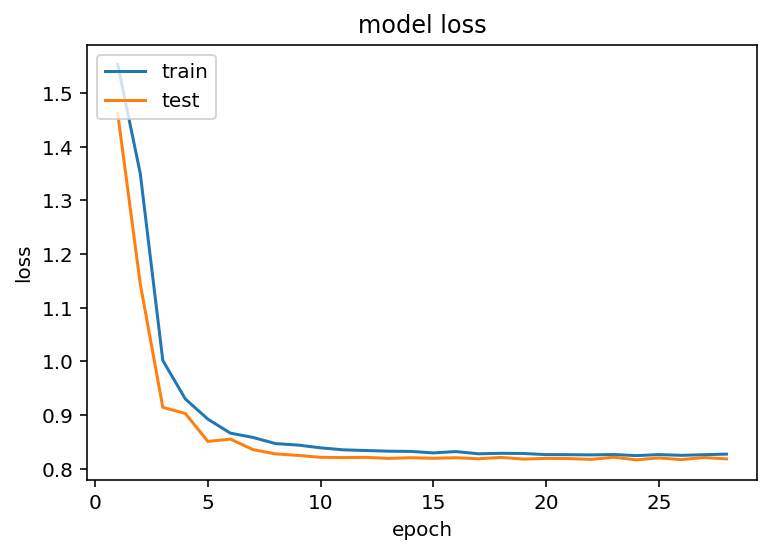

In [24]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 예측 모델링 : 머신러닝

- 동일한 파일 전처리를 위해 다시 import 후 전처리

In [157]:
food_df = pd.read_csv("food_survey.csv")
seoul_df = pd.read_csv("seoul_survey 3.csv")

In [158]:
food_df.drop("Unnamed: 0", axis=1, inplace=True)
seoul_df.drop("Unnamed: 0", axis=1, inplace=True)

In [168]:
food_df.rename(columns=({"SQ2":"gender", "K2":"adult", "K1":"juvenile",
                        "BA2":"income", "BA3":"house", "G10":"delivery"}), inplace=True)

# 결측치 = 배달을 시켜먹는 사람들의 비율 
# 제거 전에 구별로 몇퍼센트의 사람이 배달을 시켜먹는지 먼저 파악
food_df = food_df.dropna()

- 변수 설명

**[ food house ]**
    - 1 : 아파트
    - 2 : 연립다세대
    - 3 : 단독주택
    - 4 : 기타
   
**[ seoul house ]**
    - 1 : 단독주택
    - 2 : 아파트
    - 3 : 다세대주택
    - 4 : 연립주택/빌라
    - 5 : 기타

In [171]:
# 변수 값 같게 변환
change_value = {
    1 : 3, 2 : 1, 3 : 2, 4 : 3, 5 : 4
}
seoul_df["house"] = seoul_df["house"].apply(lambda x : change_value[x])

In [172]:
seoul_df.drop("WTP", axis=1, inplace=True)
seoul_df

,ID,gender,age,income,house,gu,juvenile,adult,pay
0,529,2,2,550.0,1,140.0,0.0,2.0,4
1,530,2,2,400.0,1,140.0,0.0,2.0,3
2,531,3,3,600.0,1,140.0,0.0,3.0,3
3,532,3,3,650.0,1,140.0,0.0,3.0,3
4,533,1,1,550.0,1,140.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...
19995,23845,2,2,100.0,3,530.0,0.0,2.0,1
19996,23846,3,3,550.0,3,530.0,0.0,3.0,3
19997,23847,1,1,100.0,3,260.0,0.0,1.0,4
19998,23848,2,2,450.0,2,305.0,0.0,2.0,3


## 예측 모델링

### 전처리

In [173]:
# 8개로 classification 하는 것은 힘들다고 생각
# 4가지 카테고리로 나누어보겠다
# 바꾼 것을 기준으로 5 이상이면 주 1회이상 배달을 시켜먹는 사람들
change_delivery = {
    1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4
}
food_df["delivery"] = food_df["delivery"].apply(lambda x : change_delivery[x])

In [174]:
# 지역은 예측에 필요 없으므로 제거
food_df.drop("지역", axis=1, inplace=True)

### Classification 모델 선정
-  DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, XGBClassifier, LGBMClassifier,MultinomialNB
- 가장 높은 accuracy을 보이는 알고리즘을 사용해 예측하고자 함

In [175]:
# 필요 모듈 import
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [176]:
# k-fold (교차 검증 시도)
from sklearn.model_selection import KFold
kf = KFold(n_splits=20)

In [177]:
# 독립변수, 종속변수 데이터 생성
food_X = food_df[["gender", "adult", "juvenile","income","house"]]
food_y = food_df["delivery"]

In [178]:
# 모델 이용해 acc 예측하는 함수
def model_predict_acc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    return train_acc, test_acc

In [179]:
## pip-line 생성
names = [
    'decision tree', 'random forest', 'adaboost', 'gradient boost', 'lgbm', 'xgboost', 
    'naive bayes']
    
classifiers = [
    DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(),
    AdaBoostClassifier(), XGBClassifier(), LGBMClassifier(),MultinomialNB() ]

columns = []
for i in range(1,21):
    columns.append('k{}'.format(i))
    
pipe_acc_k_df = pd.DataFrame(columns=columns)

n=0
for name, classifier in zip(names, classifiers):
    clf_pipe = Pipeline([
        ('clf', classifier)
    ])
    
    acc={}
    k=1
    for train_idx, test_idx in kf.split(food_df):
        X_train, X_test = food_X.iloc[train_idx], food_X.iloc[test_idx]
        y_train, y_test = food_y.iloc[train_idx], food_y.iloc[test_idx]
        train_acc, test_acc = model_predict_acc(clf_pipe, X_train, y_train, X_test, y_test)
        acc['k{}'.format(k)] = [train_acc,test_acc] # k1부터 k5까지 키 값으로 딕셔너리 형태 만들어주기
        k+=1        
        a_df = pd.DataFrame(acc, index=[[names[n], names[n]],['train_acc', 'test_acc']])
        
    n+=1    
    pipe_acc_k_df = pd.concat([pipe_acc_k_df, a_df], axis=0)

In [180]:
pipe_acc_k_df["mean"] = pipe_acc_k_df.mean(axis=1)

In [154]:
pipe_acc_k_df

,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,...,k12,k13,k14,k15,k16,k17,k18,k19,k20,mean
"(decision tree, train_acc)",0.669716,0.670032,0.670662,0.669716,0.670347,0.674448,0.671609,0.671609,0.669085,0.667823,...,0.673502,0.671293,0.670662,0.670032,0.667192,0.667508,0.670136,0.669820,0.669505,0.670173
"(decision tree, test_acc)",0.616766,0.592814,0.604790,0.616766,0.574850,0.532934,0.568862,0.604790,0.604790,0.622754,...,0.550898,0.580838,0.592814,0.628743,0.646707,0.682635,0.620482,0.608434,0.548193,0.600831
"(random forest, train_acc)",0.669716,0.670032,0.670662,0.669716,0.670347,0.674448,0.671609,0.671609,0.669085,0.667823,...,0.673502,0.671293,0.670662,0.670032,0.667192,0.667508,0.670136,0.669820,0.669505,0.670173
"(random forest, test_acc)",0.610778,0.598802,0.580838,0.616766,0.610778,0.538922,0.586826,0.604790,0.628743,0.616766,...,0.544910,0.598802,0.592814,0.580838,0.646707,0.676647,0.614458,0.608434,0.566265,0.602631
"(adaboost, train_acc)",0.649527,0.650789,0.650158,0.649211,0.652050,0.655836,0.655836,0.649527,0.645426,0.647003,...,0.654890,0.648265,0.651735,0.648265,0.648896,0.647003,0.648691,0.651529,0.651529,0.650348
"(adaboost, test_acc)",0.670659,0.604790,0.628743,0.616766,0.598802,0.532934,0.598802,0.616766,0.670659,0.658683,...,0.556886,0.628743,0.622754,0.634731,0.670659,0.700599,0.632530,0.614458,0.602410,0.623608
"(gradient boost, train_acc)",0.634385,0.635647,0.635016,0.636593,0.635647,0.639432,0.638170,0.634385,0.634700,0.635016,...,0.637224,0.635962,0.637224,0.636909,0.632808,0.632177,0.635762,0.635446,0.637969,0.635885
"(gradient boost, test_acc)",0.670659,0.610778,0.634731,0.610778,0.646707,0.550898,0.580838,0.634731,0.652695,0.670659,...,0.556886,0.634731,0.610778,0.628743,0.670659,0.700599,0.632530,0.638554,0.614458,0.628708
"(lgbm, train_acc)",0.665300,0.666877,0.666246,0.666562,0.667508,0.670347,0.666562,0.666246,0.665300,0.664669,...,0.668139,0.664353,0.666246,0.664038,0.662145,0.665300,0.666351,0.666351,0.665405,0.665931
"(lgbm, test_acc)",0.646707,0.616766,0.598802,0.610778,0.592814,0.532934,0.586826,0.604790,0.610778,0.646707,...,0.562874,0.604790,0.604790,0.604790,0.658683,0.682635,0.632530,0.608434,0.554217,0.609520


In [181]:
pipe_acc_k_df.loc["(Sequential, test_acc)", "mean"] = 0.6306

In [182]:
# test의 mean만 뽑아내기
test = list(range(1,14,2))
test.append(14)

pd.DataFrame(pipe_acc_k_df.iloc[test, 20]).sort_values(by="mean",
                                                       ascending=False)

,mean
"(gradient boost, test_acc)",0.633440
"(Sequential, test_acc)",0.630600
"(adaboost, test_acc)",0.630287
"(xgboost, test_acc)",0.619480
"(naive bayes, test_acc)",0.615410
"(lgbm, test_acc)",0.614513
"(random forest, test_acc)",0.606851
"(decision tree, test_acc)",0.589255


**=> test에 적용 결과 성능이 가장 좋게 나온 모델은 gradient boost**

이에 대한 하이퍼 파라미터 튜닝을 통해 accuracy를 높이도록

### 선정 모델 하이퍼 파라미터 튜닝

In [183]:
from sklearn.model_selection import GridSearchCV
grid_search_df = pd.DataFrame()         
gs_cv = GridSearchCV(GradientBoostingClassifier(), 
                     {'n_estimators' : list(range(50,500,50)),'learning_rate' : np.linspace(0.05, 0.6, 20)},
                     verbose=2, refit=False, n_jobs=-1, cv=KFold())
gs = gs_cv.fit(X_train, y_train)
grid_dict = {}

for m in range(len(list(gs.best_params_.keys()))):
            grid_dict[list(gs.best_params_.keys())[m]] = list(gs.best_params_.values())[m]
grid_dict["best score"] = gs.best_score_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 14.7min finished


In [184]:
# gradient boost의 best parameters
grid_dict

{'learning_rate': 0.05, 'n_estimators': 50, 'best score': 0.6376760365187829}

In [185]:
# 하이퍼 파라미터 튜닝 후 accuracy 검증
names = ['gradient boost']
    
classifiers = [GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 50)]

columns = []
for i in range(1,51):
    columns.append('k{}'.format(i))
    
pipe_acc_k_df = pd.DataFrame(columns=columns)

n=0
for name, classifier in zip(names, classifiers):
    clf_pipe = Pipeline([
        ('clf', classifier)
    ])
    
    acc={}
    k=1
    for train_idx, test_idx in kf.split(food_df):
        X_train, X_test = food_X.iloc[train_idx], food_X.iloc[test_idx]
        y_train, y_test = food_y.iloc[train_idx], food_y.iloc[test_idx]
        train_acc, test_acc = model_predict_acc(clf_pipe, X_train, y_train, X_test, y_test)
        acc['k{}'.format(k)] = [train_acc,test_acc] # k1부터 k5까지 키 값으로 딕셔너리 형태 만들어주기
        k+=1        
        a_df = pd.DataFrame(acc, index=[[names[n], names[n]],['train_acc', 'test_acc']])
        
    n+=1    
    pipe_acc_k_df = pd.concat([pipe_acc_k_df, a_df], axis=0)

In [186]:
pipe_acc_k_df.mean(axis=1)

(gradient boost, train_acc)    0.651292
(gradient boost, test_acc)     0.642023
dtype: float64

**=>gradient boost의 test accuracy : 0.641162**

근소한 차이지만 성능 향상

## 모델링 적용 및 예측

In [188]:
# 모델링 되어있는 것과 scale을 맞춰주기 위함
seoul_df["income"] = seoul_df["income"]/100

In [189]:
# gu는 카테고리 
seoul_df["gu"] = seoul_df["gu"].astype("category")

In [190]:
# 예측을 위한 독립변수 추출
seoul_X = seoul_df[["gender", "income", "house", "juvenile", "adult"]]

In [191]:
gb = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 50)
gb.fit(food_X, food_y)
gb_pred = gb.predict(seoul_X)

In [192]:
seoul_df["delivery"] = gb_pred

In [207]:
seoul_df.delivery.value_counts()

3    15675
2     3518
4      807
Name: delivery, dtype: int64

## 시범사업 지역 선정
- pay가 4 이상인 가구 중 (환경부담금 지출 의사가 있는 가구) delivery가 3 이상 (배달을 주 1회 이상 시켜먹는 가구) 비율이 가장 높은 구를 시범사업 지역

In [193]:
payndelivery = seoul_df[seoul_df.pay >= 4]
payndelivery = payndelivery[seoul_df.delivery >= 3]

In [194]:
gu_paydelivery = payndelivery.groupby("gu").size()

In [195]:
gu_choice = pd.DataFrame(payndelivery.groupby("gu").size() / seoul_df.groupby("gu").size() *100,
             index=gu_paydelivery.index)

In [196]:
gu_choice.reset_index(inplace=True)

**구별 다회용기 구독 시스템 잠재 고객 수 분석을 위해 서울시 가구 수 데이터 로드**

출처 : 서울 정보소통광장 (2020.05)

In [197]:
# 구별 코드를 이름으로 변경
mygu = {110:'종로구', 140:'중구', 170:'용산구', 200:'성동구', 215:'광진구', 230:'동대문구', 260:'중랑구',
        290:'성북구', 305:'강북구', 320:'도봉구', 350:'노원구', 380:'은평구', 410:'서대문구', 440:'마포구',
        470:'양천구', 500:'강서구', 530:'구로구', 545:'금천구', 560:'영등포구', 590:'동작구', 620:'관악구',
        650:'서초구', 680:'강남구', 710:'송파구', 740:'강동구'}

gu_choice["gu"] = gu_choice["gu"].apply(lambda x : mygu[x])

In [203]:
pilot_gu = gu_choice.sort_values(0, ascending=False)
pilot_gu

,gu,0
13,마포구,40.517241
21,서초구,39.926740
6,중랑구,37.200957
1,중구,35.625000
10,노원구,35.287731
18,영등포구,34.076828
14,양천구,32.971014
22,강남구,32.622601
23,송파구,31.902439
9,도봉구,30.191257


- 마포구, 서초구가 가장 높은 것으로 예측
- 이후 시각화 진행

In [204]:
# 파일 저장
pilot_gu.to_csv("pilot_gu.csv")